# Reinforcement Learning | Continuous Control | Deep Deterministic Policy Gradient (DDPG) agent | Unity Reacher (robot arm) environment

---

This notebook, shows you how to implement and train an actor-critic [DDPG](https://arxiv.org/abs/1509.02971) (Deep Deterministic Policy Gradient) Reinforcement Learning agent to steer double-jointed robot arms towards target locations in a Unity simulation environment called Reacher.

**Why?** Reinforcement Learning (RL) is one of the most fascinating areas of Machine Learning! You might have heared about the breakthrough application [AlphaGo by DeepMind](https://deepmind.com/research/case-studies/alphago-the-story-so-far) which competed in the ancient game of [Go](https://en.wikipedia.org/wiki/Go_(game)) against the (16 times) world champion Lee Sedol and ultimately won 4-1.  RL is quite intuitive, because we use positive and negative feedback to learn tasks via interaction - just like we would train a dog. From controlling robots to stock trading to solving complex simulated tasks, RL has many applications and bears lots of potential. This notebook is a project submission for the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). My contribution lays mainly in section 1, 5, 6, and 7.

**What?** The [Unity](https://en.wikipedia.org/wiki/Unity_(game_engine)) environment shown in this notebook is called [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md). In this episodic task the agent can control the movement of 20 double-jointed robot arms and the goal is to move each robot hand into a green target location and keep it there. If this is achieved the agent receives positive reward of +0.1 each time step and ultimately a positive game core. This is what a trained agent looks like!

<img src="imgs/agent.gif" width="450" align="center" title="reacher unity environment"/>

**How?** This notebook will step you through the process how to build and train a DDPG agent! Keep reading.


### 1. The Learning Algorithm

The Deep Deterministic Policy Gradient aka [DDPG algorithm](https://arxiv.org/abs/1509.02971) by Lillicrap et al. (2015) is an actor-critic, off-policy, model-free Reinforcement Learning approach. It extends the renown [DQN algorithm](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) to solve environments with continuous action spaces and further builds on top of its older brother the [DPG algorithm](http://proceedings.mlr.press/v32/silver14.pdf) algorithm by Silver et al. (2014). Let's briefly dissect the concepts mentioned: 

**Actor-critic** methods have an actor model to select actions, and a critic model to criticize the action selection to make it better. They combine critic-only and actor-only methods. Critic-only methods are Value-Based methods. They aim to find the optimal (action) value function first and then derive an optimal policy from it by, for instance, selecting the (epsilon-) greedy action. This is the action that is likely to yield the most expected return. Actor-only methods are Policy-Based methods, which search for the optimal policy directly, without calculating the (action) value function first. In actor-critic methods the actor model learns a policy to determine the next action probabilities and the critic model learns a value function that is used to determine how well the actor policy is performing. An advantage of actor-critic models is that they usually have good convergence properties.

In **off-policy** methods the policy used for interacting with an environment is not the policy that is being learned. The off-policy agent aims to learn the optimal policy (which yields the maximum expected reward) directly, though the policy it has at hand to interact with the environment is not optimal yet and therefore different. In fact the policy might be a random policy in the beginning. An example algorithm is DQN (checkout my DQN notebook [here](https://github.com/ImmanuelXIV/dqn-navigate/blob/master/Navigation.ipynb) if you are interested). On-policy methods, on the other hand, aim to optimize the same policy they use for interacting with the environment.

**Model-free** Reinforcement Learning tasks are framed as (finite) Markov Decision Processes (MDPs). MDPs consist of: a (finite) set of states $S$, a (finite) set of actions $A$, a set of rewards $R$, the discount rate $\gamma$, and the one-step dynamics of the environment. In model-free approaches the agent does not have access to the function that yields the reward $R(s,a)$, and neither to the one-step transition dynamic $T(s'|s,a)$ that returns the next state $s'$. If the agent has access to them as well it is a model-based approach, which can utilize planning algorithms for decision-making.

**Continuous action space** means that the actions our agent controlls are not e.g. four discrete "left, right, up, down" actions but they can take continuous values in intervals of let's say [-1 1], [-7.9 7.9], [-37.8 37.8], [-23 23]. Since there are unlimited different combinations of continuous actions this makes the learning task much difficult. Constinuous action spaces are common in robot motion tasks. 

Underneath is the DDPG algorithm taken from [Lillicrap et al.](https://arxiv.org/abs/1509.02971). Please refer to the paper for more details.

<img src="imgs/ddpg-algorithm.png" width="600" align="center" title="ddpg algorithm"/>

The chosen hyperparameters for the actor and critic models, the noise function, and the replay buffer are as follows. Refer to the code for more details.

- SEED = 123
- GAMMA = 0.98
- LR_A = 1e-4
- LR_C = 1e-3
- WEIGEHT_DECAY = 0
- TAU = 1e-3
- BATCH_SIZE = 128
- C = 20
- D = 10
---
- mu=0.0
- theta=0.15
- sigma=0.2
---
- BUFFER_SIZE = 1e6


The chosen model architecture for the actor and critic neural networks are:

```python
Actor(
  (fc1): Linear(in_features=33, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=200, out_features=300, bias=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)

Critic(
  (fc1): Linear(in_features=33, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=204, out_features=300, bias=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
```


### 2. Start the Environment

Begin by importing the necessary packages. If the code cell below returns an error, please revisit the project instructions in the `README.md` file to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded (see `README.md`). For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is uncommented and executed, you will watch the agent's performance, and how it selects an action at random each time step.  A window should pop up that allows you to observe the agent as it moves the robot arms in the environment.

In [5]:
"""
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print('Episode finished.') 
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()
"""

"\nenv_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \nstates = env_info.vector_observations                  # get the current state (for each agent)\nscores = np.zeros(num_agents)                          # initialize the score (for each agent)\nwhile True:\n    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n    env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n    next_states = env_info.vector_observations         # get next state (for each agent)\n    rewards = env_info.rewards                         # get reward (for each agent)\n    dones = env_info.local_done                        # see if episode finished\n    scores += env_info.rewards                         # update the score (for each agent)\n    states = next_states                               # roll over states to next ti

### 5. Train a DDPG agent 

I'd recommend that you open the files `ddpg_agent.py`, `ac_models.py`, `noise.py`, and `replaybuffer.py` in different tabs and walk through the code step by step to gather a deeper understanding. Running this code until the environment was solved took approximately 00:35h on a Nvidia Tesla K80 gpu and about 01:20h on a 2.7 GHz Intel Core i5. If you just want to see a trained agent controlling the robot arms, then jump to section 6.

In [6]:
import numpy as np
import torch
from ddpg_agent import Agent
from collections import deque


num_episodes = 200      # number of episodes to train
t_max = 1000            # maximum number of time steps per episode
print_every = 10        # print states every couple of steps

def run_ddpg(agent, env):
    """ Initialize the agent.
        Params
        ======
            agent:      Agent object
            env:        Unity Reacher environment
    """
    scores_all = list()
    scores_window = deque(maxlen=100)
    best_score = -np.inf
    
    for i_episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get current state (each agent)
        scores = np.zeros(num_agents)                          # initialize score (each agent)
        agent.noise.reset()                                    # reset noise each episode
        
        for t in range(t_max):
            actions = agent.select_action(states)              # select actions
            actions = np.clip(actions, -1, 1)                  # clip actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to env
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)

            scores += rewards                                  # update the score (each agent)
            states = next_states                               # roll over to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        scores_all.append(np.mean(scores))
        scores_window.append(np.mean(scores))
        
        print('\r{}/{} Episode. Total score (averaged over agents): {:.3f}'.format(i_episode, num_episodes, \
                                                                               np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\r{}/{} Episode. Total score (averaged over agents): {:.3f}'.format(i_episode, num_episodes, \
                                                                               np.mean(scores_window)))
        if np.mean(scores_window) >= 30:
            print('\rEnvironment solved after {} episodes. Total score (averaged over agents): {:.3f}'\
                  .format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoints/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoints/checkpoint_critic.pth')
            break
        
    return scores_all

In [7]:
agent = Agent(state_size, action_size)
scores = run_ddpg(agent, env)

10/200 Episode. Total score (averaged over agents): 1.218
20/200 Episode. Total score (averaged over agents): 2.211
30/200 Episode. Total score (averaged over agents): 5.434
40/200 Episode. Total score (averaged over agents): 10.224
50/200 Episode. Total score (averaged over agents): 15.009
60/200 Episode. Total score (averaged over agents): 18.178
70/200 Episode. Total score (averaged over agents): 20.369
80/200 Episode. Total score (averaged over agents): 21.968
90/200 Episode. Total score (averaged over agents): 23.436
100/200 Episode. Total score (averaged over agents): 24.259
110/200 Episode. Total score (averaged over agents): 26.720
120/200 Episode. Total score (averaged over agents): 29.014
Environment solved after 126 episodes. Total score (averaged over agents): 30.017


In [8]:
scores = np.array(scores)
x = np.where(scores >= 30)
print('The first time a score >= 30 was reached at episode {}.'.format(x[0][0]))
print('Max score reached: ', np.amax(scores))

The first time a score >= 30 was reached at episode 39.
Max score reached:  37.52649916121736


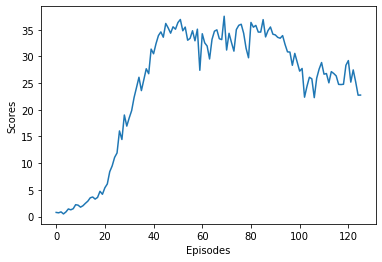

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Scores')
plt.xlabel('Episodes')
plt.show()

### 6. Watch a trained agent

Run the code cell below to load a trained agent and run it in the environment. You might have to restart the notebook Kernel and only run the code in sections 2 and 3, before running the following cell.


In [10]:
import torch
import numpy as np
from ddpg_agent import Agent

num_episodes = 2

agent = Agent(state_size, action_size)
agent.actor_local.load_state_dict(torch.load('checkpoints/checkpoint_actor.pth', \
                                             map_location=torch.device('cpu')))
agent.critic_local.load_state_dict(torch.load('checkpoints/checkpoint_critic.pth', \
                                              map_location=torch.device('cpu')))

for i_episode in range(num_episodes):
    env_info = env.reset(train_mode=False)[brain_name]         # reset the environment    
    states = env_info.vector_observations                      # get current state (each agent)
    scores = np.zeros(num_agents)                              # initialize score (each agent)
    
    while True:
        actions = agent.select_action(states, ou_noise=False)  # select actions
        actions = np.clip(actions, -1, 1)                      # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]               # send all actions to env
        next_states = env_info.vector_observations             # get next state (each agent)
        rewards = env_info.rewards                             # get reward (for each agent)
        dones = env_info.local_done                            # see if episode finished
        scores += env_info.rewards                             # update score (each agent)
        states = next_states                                   # roll over to next time step
        if np.any(dones):                                      # exit loop if epis. finished
            print('Episode {} finished.'.format(i_episode)) 
            break
            
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()

Episode 0 finished.
Episode 1 finished.
Total score (averaged over agents) this episode: 33.791499244701114


### 7. Ideas for future work

To reach even better results one could tweak the network architectures of the actor and critic in `ac_models.py`, and as well, focus on e.g. batch normalization, the noise function, and the update parameters C, and D, which had a strong impact on learning performance of the DDPG agent. More simulation time might yield slightly better results. To speed up learning one could train similar ddpg agents on multiple gpus and then average the learned network parameters for one final ddpg agent. Another approach would be to implement a different algorithm such as [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf), and [D4PG](https://openreview.net/pdf?id=SyZipzbCb) which use multiple (non-interacting, and parallel) copies of the same agent to distribute the task of gathering experience.  

This notebook is a project submission for the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). My contribution lays mainly in section 1, 5, 6, and 7. If you are interested to learn more about Deep Reinforcement Learning, I can highly recommend it.